# Predicting Round, Category and Value of a Jeopardy! Question using Logistic Regression

In [1]:
import torch
import torchtext
import torchdata
import portalocker
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
# Function to ensure the correct versions are installed.
def check_lib_versions():
    libversions = {torch: "2.0",  torchtext: "0.15.1", torchdata: "0.6.0",
                   portalocker: "2.7.0"}
    for l, v in libversions.items():
        try:
            assert l.__version__ == v
        except:
            name = [n for n in globals() if globals()[n] is l][0]
            print(f'Error: The version of {name} should be {v}.')
check_lib_versions()

In [3]:
filename = 'jeopardy_json.json'
# questions = {}
# rounds = {}
# categories = {}
# values = {}

with open(filename, 'r', encoding='iso-8859-1') as f:
    data = json.load(f)

# data

In [4]:
train_size = int(0.8*len(data))
val_size = int(0.1*len(data))
test_size = int(0.1*len(data))

train_size

173544

In [5]:
# from torch.utils.data import random_split
# FIGURE OUT HOW TO USE RANDOM_SPLIT WITH DATASET CLASS

train_data = data[:train_size]
val_data = data[:val_size]
test_data = data[:test_size]

Round lables:
0 - Jeopardy!
1 - Double Jeopardy!
2 - Final Jeopardy!
3 - Tiebreaker

In [6]:
examples_rounds = []
examples_categories = []
examples_values = []

def create_label_text_pairs(train_data):
    for row in train_data:
        if row['round'] == 'Jeopardy!':
            round_label = 1
        elif row['round'] == 'Double Jeopardy!':
            round_label = 2
        elif row['round'] == 'Final Jeopardy!':
            round_label = 3
        elif row['round'] == 'Tiebreaker':
            round_label = 4
        examples_rounds.append((round_label, row['question']))
        examples_categories.append((row['category'], row['question']))
        examples_values.append((row['value'], row['question']))
    return examples_rounds, examples_categories, examples_values

examples_rounds, examples_categories, examples_values = create_label_text_pairs(train_data)
examples_rounds_iter = iter(examples_rounds)
examples_categories_iter = iter(examples_categories)
examples_values_iter = iter(examples_values)

print(next(examples_rounds_iter))
print(next(examples_categories_iter))
print(next(examples_values_iter))

(1, "'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'")
('HISTORY', "'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'")
('$200', "'For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory'")


In [7]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(train_iter):
    for _, text in train_iter:
        yield tokenizer(text)

In [8]:
# Only inlcude words that occur at least 1000 times in the training data.
# Also let "<unk>" represent unknown words, i.e., words not in the vocabulary.

vocab = build_vocab_from_iterator(
    yield_tokens(examples_categories_iter), specials=["<unk>"], min_freq=1000)

In [9]:
# Task 1: Print the number of words in vocab.
print("Number of words in vocab:", len(vocab))

# Task 4: Find out what index vocab has for the special unknown token "<unk>" and set it as the default index of vocab.
unk_idx = vocab["<unk>"]
vocab.set_default_index(unk_idx)

Number of words in vocab: 253


In [10]:
# Print the indices corresponding to the text in example1
example1 = next(examples_rounds_iter)
print(example1)
print([vocab[token] for token in tokenizer(example1[1])])

(1, "'No. 2: 1912 Olympian; football star at Carlisle Indian School; 6 MLB seasons with the Reds, Giants & Braves'")
[1, 83, 7, 47, 0, 0, 0, 174, 32, 0, 0, 218, 221, 0, 0, 18, 2, 0, 3, 0, 11, 0, 1]


In [11]:
from torch.utils.data import DataLoader

def collate_into_bow(batch):
    labels = []
    bow_vectors = []
    for label, text in batch:
        labels.append(label-1)
        bow_vector = [0.0] * len(vocab)
        tokens = tokenizer(text)
        for t in tokens:
            t_idx = vocab[t]
            bow_vector[t_idx] += 1
        bow_vector = [x / len(tokens) for x in bow_vector]
        bow_vectors.append(bow_vector)
    result = (torch.tensor(labels), torch.tensor(bow_vectors))

    return result


def test_collate():
    w1 = vocab.lookup_token(3)
    w2 = vocab.lookup_token(7)
    w3 = vocab.lookup_token(8)
    w4 = vocab.lookup_token(9)
    examples = [
        (1, " ".join([w1, w2, w3, w4])),
        (2, " ".join([w2, w1, w3, w4])),
        (4, " ".join([w4, w2, w3, w4])),
        (3, " ".join([w2, w2, w2, w4])),
        (3, " ".join([w1, w2])),

    ]
    bowt = torch.tensor(
        [
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.50],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.25],
            [0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.00],

        ]) 
    lt, tt = collate_into_bow(examples)
    assert lt.shape == torch.Size([5])
    assert tt.shape == torch.Size([5, len(vocab)])
    print(lt, tt)
    assert torch.equal(lt, torch.tensor([0, 1, 3, 2, 2]))
    assert torch.equal(tt[:,:10], bowt)
    assert tt[:,10:].sum().item() == 0.00
    print('Test passed.')
    
test_collate()

tensor([0, 1, 3, 2, 2]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Test passed.


### BOW Classifier

In [12]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [13]:
train_data = data[:train_size]
examples_rounds, examples_categories, examples_values = create_label_text_pairs(train_data)
examples_rounds_iter = iter(examples_rounds)
examples_categories_iter = iter(examples_categories)
examples_values_iter = iter(examples_values)

train_data = examples_rounds_iter
num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)

### Create function to train one epoch

In [14]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        # print(f"label, text:", label, text)
        model.zero_grad()
        log_probs = model(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')

### Create function to compute accuracy

In [15]:
def get_accuracy(dataloader):
    model.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy

# get_accuracy(valid_dataloader)

In [16]:
from torch.utils.data.dataset import random_split

BATCH_SIZE = 64 # batch size for training

train_data = data[:train_size]
examples_rounds, examples_categories, examples_values = create_label_text_pairs(train_data)
examples_rounds_iter = iter(examples_rounds)
examples_categories_iter = iter(examples_categories)
examples_values_iter = iter(examples_values)

train_valid_data = examples_rounds_iter
train_valid_data = list(train_valid_data)
num_train = int(len(train_valid_data) * 0.95)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

### Training

At iteration 500 the loss is 0.762.
At iteration 1000 the loss is 0.802.
At iteration 1500 the loss is 0.987.
At iteration 2000 the loss is 0.872.
At iteration 2500 the loss is 0.697.
At iteration 3000 the loss is 0.734.
At iteration 3500 the loss is 0.819.
At iteration 4000 the loss is 0.847.
At iteration 4500 the loss is 0.903.
At iteration 5000 the loss is 0.746.
At iteration 5500 the loss is 0.807.
At iteration 6000 the loss is 0.798.
At iteration 6500 the loss is 0.742.
At iteration 7000 the loss is 0.796.
At iteration 7500 the loss is 0.809.

After epoch 1 the validation accuracy is 0.540.

At iteration 500 the loss is 0.713.
At iteration 1000 the loss is 0.790.
At iteration 1500 the loss is 0.708.
At iteration 2000 the loss is 0.725.
At iteration 2500 the loss is 0.844.
At iteration 3000 the loss is 0.906.
At iteration 3500 the loss is 0.728.
At iteration 4000 the loss is 0.854.
At iteration 4500 the loss is 0.852.
At iteration 5000 the loss is 0.701.
At iteration 5500 the loss 

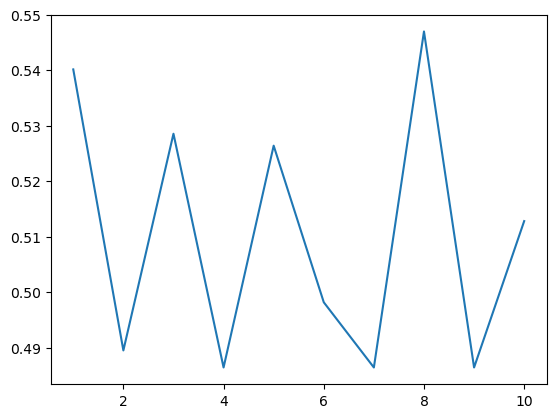

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 10 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)